# Generating Images using Compositional Pattern-Producing Networks (CPPN)  

Materials for Methods 2: Digital Systems, Week 4: **Digital Images x Data Science**.   
Author: Jasper Shuoyang Zheng



We will use a machine learning library called [PyTorch](https://pytorch.org/get-started). It will help us create the pixel dataset, create the neural network, and train the neural network.

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler

In [ ]:
img = Image.open('img.jpg').convert('RGB').resize((256, 256))

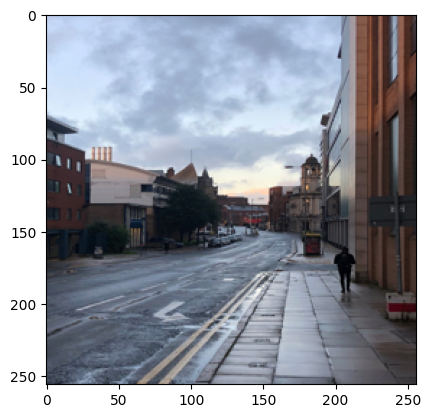

In [ ]:
img_matrix = np.array(img)
plt.imshow(img_matrix)
plt.show()

## Step 1 - Creating the Pixel Dataset

**Generating the coordinates**   

Similar to how we create an image in Cartesian coordinates, we iterate through all rows and columns to create a pair of XY coordinates, and retrieve the RGB values on that coordinates.  

The coordinates will be the inputs of our neural network, the RGB values will be the targets (outputs).

In [ ]:
def create_pixel_dataset(img_matrix):
  """Converts an image matrix into a dataset of pixels.

  Args:
    img_matrix: A NumPy array representing the image.

  Returns:
    A tuple containing two NumPy arrays: inputs (x, y coordinates) and targets (RGB values).
  """
  height, width, channels = img_matrix.shape
  coordinates = []
  targets = []
  for y in range(height):
    for x in range(width):
      coordinates.append([x, y])
      targets.append(img_matrix[y, x])
  return np.array(coordinates), np.array(targets)

In [ ]:
coordinates, targets = create_pixel_dataset(img_matrix)

print("Coordinates shape:", coordinates.shape)
print("Targets shape:", targets.shape)

# Example to access data point
print("Coordinates (x,y):", coordinates[0])
print("Target RGB:", targets[0])

Coordinates shape: (65536, 2)
Targets shape: (65536, 3)
Coordinates (x,y): [0 0]
Target RGB: [185 198 230]


**Normalisation**  

Most neural networks require the data to be normalised (standardise) to zero mean and unit variance. We use sklearn's StandardScaler, which can help us to normalised original data, and transform normalised data back to original scale.

In [ ]:
scaler_coordinates = StandardScaler()
scaler_targets = StandardScaler()
scaler_coordinates.fit(coordinates)
scaler_targets.fit(targets)

coordinates_scaled = scaler_coordinates.transform(coordinates)
targets_scaled = scaler_targets.transform(targets)

In [ ]:
# wrap all data into pytorch tensors
coordinates_scaled = torch.tensor(coordinates_scaled, dtype=torch.float32)
targets_scaled = torch.tensor(targets_scaled, dtype=torch.float32)

Now we create a dataloader as our pixel dataset. The dataloader is an utility class in PyTorch to handle data batching and loading.  

In [ ]:
batch_size = 32

data_loader = DataLoader(TensorDataset(coordinates_scaled, targets_scaled), batch_size=batch_size, shuffle=True)

print(f'number of training batches: {len(data_loader)}')

number of training batches: 2048


## Step 2 - Create the Neural Network  

We haven't covered neural networks in our journey. It's okay if you're unfamiliar with the concept - just think of our neural network as a "not that smart" AI model that **"memorises" the RGB values on all coordinates**.  

We'll first create a neural network, and then use the pixel dataset to **train the neural network**.

In [ ]:
from math import pi

class Network(nn.Module):
    def __init__(self, input_size=2, hidden_size=128, output_size=3, gauss_scale=0.1, mapping_size=128):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(mapping_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, output_size)
        self.relu = nn.LeakyReLU()

        self.gauss_scale = gauss_scale
        self.mapping_size = mapping_size
        self.register_buffer('two_pi', torch.tensor(pi).mul(2.))

        B = torch.normal(0, gauss_scale, size=(self.mapping_size, input_size))
        self.register_buffer('B_T', B.T)

    # An extra fourier mapping layer to transform pixels from the Cartesian domain to the frequency domain
    def fourier_feature_mapping(self, x, B_T):
        x_proj = (self.two_pi*x) @ B_T
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

    def forward(self, x):
        x = self.fourier_feature_mapping(x, self.B_T)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

    def predict(self, x, device):
        with torch.no_grad():
            x = scaler_coordinates.transform(x.cpu().numpy())
            x = torch.tensor(x, dtype=torch.float32)
            x = self.forward(x.to(device))
            x = scaler_targets.inverse_transform(x.cpu().numpy())
        return x


In [ ]:
# instantiate and network
net = Network()
print(net)

Network(
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=3, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)


In [ ]:
# Create random input tensor
input_tensor = torch.tensor([[2,3],[4,6]])  # Batch size 1, 2 input features
output_tensor = net.predict(input_tensor, 'cpu')
print("Output:", output_tensor)

Output: [[121.66063  131.98578  141.26765 ]
 [121.660034 131.97217  141.26949 ]]


## Step 3 - Train the Neural Network on our Pixel Dataset

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Define the loss function
criterion = nn.MSELoss()

In [ ]:
# Training loop
num_epochs = 10  # Adjust as needed
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device {device}")

net = net.to(device)

for epoch in range(num_epochs):
  for i, (batch_coordinates, batch_targets) in enumerate(data_loader):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = net(batch_coordinates.to(device))

    # Calculate the loss
    loss = criterion(outputs, batch_targets.to(device))

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    if (i+1) % 512 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}')

  print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training finished.')


Training on device cuda
Epoch [1/10], Step [512/2048], Loss: 0.1902
Epoch [1/10], Step [1024/2048], Loss: 0.1472
Epoch [1/10], Step [1536/2048], Loss: 0.1274
Epoch [1/10], Step [2048/2048], Loss: 0.1168
Epoch [1/10], Loss: 0.1168
Epoch [2/10], Step [512/2048], Loss: 0.1350
Epoch [2/10], Step [1024/2048], Loss: 0.2492
Epoch [2/10], Step [1536/2048], Loss: 0.0861
Epoch [2/10], Step [2048/2048], Loss: 0.1218
Epoch [2/10], Loss: 0.1218
Epoch [3/10], Step [512/2048], Loss: 0.1872
Epoch [3/10], Step [1024/2048], Loss: 0.1620
Epoch [3/10], Step [1536/2048], Loss: 0.0736
Epoch [3/10], Step [2048/2048], Loss: 0.0754
Epoch [3/10], Loss: 0.0754
Epoch [4/10], Step [512/2048], Loss: 0.1251
Epoch [4/10], Step [1024/2048], Loss: 0.1121
Epoch [4/10], Step [1536/2048], Loss: 0.1110
Epoch [4/10], Step [2048/2048], Loss: 0.0632
Epoch [4/10], Loss: 0.0632
Epoch [5/10], Step [512/2048], Loss: 0.0841
Epoch [5/10], Step [1024/2048], Loss: 0.1820
Epoch [5/10], Step [1536/2048], Loss: 0.1363
Epoch [5/10], Step

## Now let's check our neural net's memory

In [ ]:
batch_size = 32

data_loader_pred = DataLoader(TensorDataset(torch.tensor(coordinates)), batch_size=batch_size, shuffle=False)


In [ ]:
preds = []
net = net.to(device)
for i, batch_coordinates in enumerate(data_loader_pred):
  pred = net.predict(batch_coordinates[0], device)
  preds.append(pred)
  if (i+1) % 512 == 0:
    print(f'Batch [{i+1}/{len(data_loader)}]')
preds_tensor = np.concatenate(preds, axis=0)

Batch [512/2048]
Batch [1024/2048]
Batch [1536/2048]
Batch [2048/2048]


In [ ]:
preds_tensor = np.clip(preds_tensor,0,255).astype(np.uint8)
preds_tensor = preds_tensor.reshape(256, 256, 3)
preds_tensor.shape

(256, 256, 3)

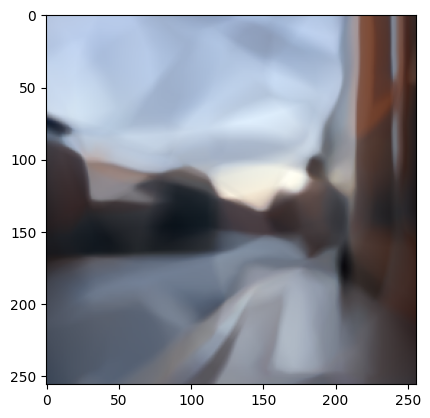

In [ ]:
plt.imshow(preds_tensor)
plt.show()